In [12]:
VOICED = set(['AA', 'AE', 'AH', 'AO', 'AW', 'AY', 'EH', 'EY', 'IH', 'IY', 'OW', 'OY', 'UH', 'UW', "ER"])
CMU2VISEME = {"AA":"Ah", "AO":"Ah", "AY":"Ah", "AW":"Ah","AE":"Aa",
              "EY":"Ah","UH":"Uh", "UW":"U","IH": "Ih","IY": "Ih","EH": "Eh","HH": "Eh","UH": "Eh","AH": "Eh",
              "ER": "Eh","OW":"Oh","OY":"Oh","R":"R","D":"LNTD","T": "LNTD","L":"LNTD","N":"LNTD","NG":"LNTD",
              "F":"FV","V":"FV","B":"BP","M":"M","P":"BP","CH":"ShChZh","SH":"ShChZh","ZH":"ShChZh",
              "S": "SZ", "Z": "SZ","DH":"Th", "TH":"Th","G":"GK", "K":"GK","Y":"Y","JH":"J","W":"W",}
VOWELS_SLIDERS_JALI = set(['Ih_pointer', 'Ee_pointer', 'Eh_pointer', 'Aa_pointer', 'U_pointer', 'Uh_pointer'
                           , 'Oo_pointer', 'Oh_pointer', 'Schwa_pointer', 'Eu_pointer', "Ah_pointer"])
CONSONANTS_SLIDERS_JALI = set(["M_pointer", "BP_pointer", "JY_pointer", "Th_pointer", "ShChZh_pointer", "SZ_pointer", "GK_pointer", "LNTD_pointer", "R_pointer", "W_pointer", "FV_pointer"])
CONSONANTS_SLIDERS_NOJAW_JALI = set(["Ya_pointer", "Ja_pointer", "Ra_pointer", "FVa_pointer", "LNTDa_pointer", "Ma_pointer", "BPa_pointer", "Wa_pointer", "Tha_pointer", "GKa_pointer"])
JALI_SLIDERS_SET = set.union(VOWELS_SLIDERS_JALI, CONSONANTS_SLIDERS_JALI, CONSONANTS_SLIDERS_NOJAW_JALI)

In [13]:
def generate_basic_viseme_curve(start, end, value, sustain=1, decay = 0.75, onset=0.1, offset=0):
    interval = []
    interval.append([start-onset, 0])
    # second point is when the belting starts 
    interval.append([start, 1 * value])
    # third point emphasizes decay, it happens 75% down the interval
    if sustain < 1:
        interval.append([start + sustain * (end - start), decay * value])
        # last point is where the furrowing ends
        interval.append([end+offset, 0])
    elif sustain == 1:
        interval.append([end, value])
        # last point is where the furrowing ends
        interval.append([end+offset, 0])
    return interval

In [14]:
from util.SongDataStructure import *
from util.pitch_interval_estimation import *
import numpy as np
import json
from matplotlib import pyplot as plt
import os
from scipy.interpolate import interp1d

In [15]:
# load file for Jali
dir = "E:/MASC/Structured_data/rolling_in_the_deep_adele"
file_name_template = "audio"
lyric = Minimal_song_data_structure(os.path.join(dir, file_name_template+".wav"), os.path.join(dir, file_name_template+".txt"),
                                                                                             os.path.join(dir, "audio_full.TextGrid"))

In [16]:
# break the thing into sentence structures
sentences = []
current_sentence = []
for i in range(0, len(lyric.phoneme_list)):
    if lyric.phoneme_list[i] == "EOS_tag":
        sentences.append(current_sentence)
        current_sentence = []
    else:
        current_sentence.append(i)
        if i == len(lyric.phoneme_list) - 1:
            sentences.append(current_sentence)
sentences = sentences[1:] 
# sentence stores the indexes

In [17]:
phoneme_list = lyric.phoneme_list
phoneme_interval = lyric.phoneme_intervals

In [23]:
def viseme_A(val, val_max, val_min, max_val = 10):
    val = (val - val_min) / (val_max - val_min)
    return np.tanh((val)*0.53+0.55) * max_val

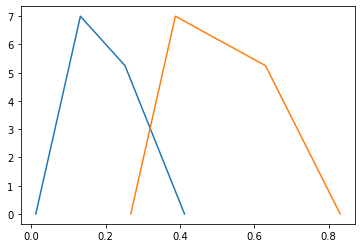

In [38]:
curve1 = viseme_interval[0]
curve2 = viseme_interval[1]

c1 = np.array(curve1).T
c2 = np.array(curve2).T

plt.plot(c1[0], c1[1])
plt.plot(c2[0], c2[1])

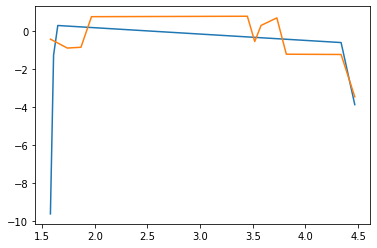

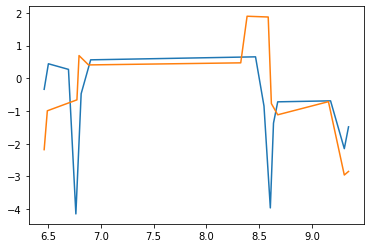

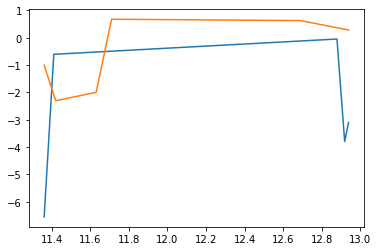

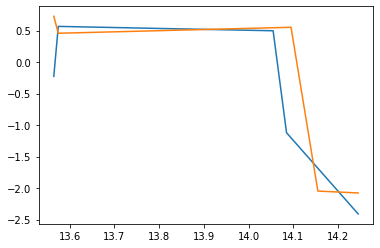

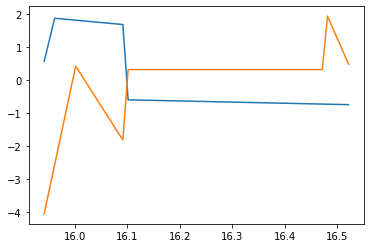

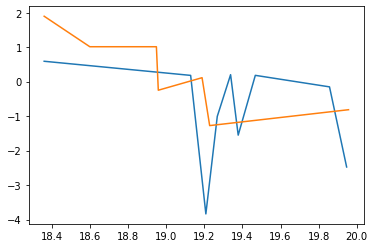

In [30]:
# animate only vowels and see how it goes
viseme_list = []
viseme_interval = []
max_activation = 8
for sentence in sentences:
    for i in range(0, len(sentence)):
        if phoneme_list[sentence[i]] in VOICED:
            xI, yI = lyric.get_I_interval(phoneme_interval[sentence[i]])
            xf, yf = lyric.get_f_interval(phoneme_interval[sentence[i]])
            xF, yF = lyric.get_F1_interval(phoneme_interval[sentence[i]])
            length_of_interval = xI[-1] - xI[0] 
            if length_of_interval <= 0.35:
                onset = 0.12
                offset = 0.12
                value = 7
                sustain = 0.75
                decay = 0.75
                curve = generate_basic_viseme_curve(phoneme_interval[sentence[i]][0], phoneme_interval[sentence[i]][1], value, sustain=sustain, 
                                            decay = decay, onset=onset, offset=offset)
                viseme_interval.append(curve)
                viseme_list.append(CMU2VISEME[phoneme_list[sentence[i]]] + "_pointer")
            else:
                onset = 0.12
                offset = 0.12
                control_pts = []
                vib = lyric.compute_vibrato_intervals(yf-savgol_filter(yf, 35, 1), xf, lyric.dt)
                vib_interval_indexs = lyric.get_subarrays_indexes_from_time_interval(vib, xI)
                for vib_int in vib_interval_indexs:
                    yI[vib_int[0]:vib_int[1]] = yI[vib_int[0]:vib_int[1]].mean()
                    yf[vib_int[0]:vib_int[1]] = yf[vib_int[0]:vib_int[1]].mean()
                slopes_I, intervals_I = efficient_piece_wise_linear_intervals(xI, yI)
                slopes_f, intervals_f = efficient_piece_wise_linear_intervals(xf, yf)
                kpx_I, kpy_I = get_key_points(xI, yI, intervals_I, __)
                kpx_f, kpy_f = get_key_points(xf, yf, intervals_f, __)
#                 plt.plot(kpx_I, (kpy_I-yI.mean())/yI.std())
#                 plt.plot(xI, (yI-yI.mean())/yI.std())
#                 plt.plot(kpx_f, (kpy_f-yf.mean())/yf.std())
#                 plt.plot(xf, (yf-yf.mean())/yf.std())
#                 plt.plot(xf, yf)
#                 plt.show()
                # onset and offset of these would be the same as regular vowels 
                control_pts.append([phoneme_interval[sentence[i]][0] - onset, 0])
                # now find the first key point - i.e. the beginning of the first plateau
                avg_pitch = 0
                total_weight = 0
                pitch_values = []
                for si in range(0, len(slopes_f)):
                    if abs(slopes_f[si]) <= 40:
                        avg_pitch = avg_pitch + (yf[intervals_f[si][0]] * (intervals_f[si][1] - intervals_f[si][0]))
                        pitch_values.append(yf[intervals_f[si][0]])
                        total_weight = total_weight + (intervals_f[si][1] - intervals_f[si][0])
                if avg_pitch == 0:
                        avg_pitch = yf.mean()
                        total_weight = 1
                pitch_values = np.array(pitch_values)
                avg_pitch = avg_pitch / total_weight
                for si in range(0, len(slopes_f)):
                    val = viseme_A(yf[intervals_f[si][0]], pitch_values.min(), yf.max())
                    if abs(slopes_f[si]) <= 50 and val > control_pts[-1][1]:
                        control_pts.append([xf[intervals_f[si][0]], val])
                    
                for si in range(len(slopes_f)-1, -1, -1):
                    if abs(slopes_f[si]) <= 50:
                        control_pts.append([xf[intervals_f[si][1]], viseme_A(yf[intervals_f[si][1]], pitch_values.min(),
                                                                         yf.max())])
                        break
                control_pts.append([phoneme_interval[sentence[i]][1] + offset, 0])
                viseme_interval.append(control_pts)
                viseme_list.append(CMU2VISEME[phoneme_list[sentence[i]]] + "_pointer")        
                
                
            

In [61]:
for i in range(1, len(viseme_list)):
    interval_i = viseme_interval[i]
    interval_i.sort(key=lambda x:x[0])
    interval_prev = viseme_interval[i-1]
    interval_prev.sort(key=lambda x:x[0])
    print(interval_prev)
    if interval_i[0][0] <= interval_prev[-1][0]:
        # there is an overlap
        interval_prev[-2][0] = interval_i[1][0]
        interval_prev[-1][0] = interval_i[1][0] + 0.12
        print(interval_i)
        viseme_interval[i-1] = interval_prev

[[0.012062500000000004, 0], [0.1320625, 7], [0.38754073689673074, 0], [0.5075407368967307, 5.25]]
[[0.26754073689673075, 0], [0.38754073689673074, 7], [0.7384294239750909, 0], [0.8584294239750909, 5.25]]
[[0.26754073689673075, 0], [0.38754073689673074, 7], [0.7384294239750909, 0], [0.8584294239750909, 5.25]]
[[0.6184294239750909, 0], [0.7384294239750909, 7], [0.9692772444213805, 0], [1.0892772444213805, 5.25]]
[[0.6184294239750909, 0], [0.7384294239750909, 7], [0.9692772444213805, 0], [1.0892772444213805, 5.25]]
[[0.8492772444213805, 0], [0.9692772444213805, 7], [1.3386337571354439, 0], [1.458633757135444, 5.25]]
[[0.8492772444213805, 0], [0.9692772444213805, 7], [1.3386337571354439, 0], [1.458633757135444, 5.25]]
[[1.2186337571354438, 0], [1.3386337571354439, 7], [1.7387154903995852, 0], [1.858715490399585, 5.25]]
[[1.2186337571354438, 0], [1.3386337571354439, 7], [1.7387154903995852, 0], [1.858715490399585, 5.25]]
[[1.4587154903995851, 0], [1.7387154903995852, 7.601529306326573], [3.

In [58]:
# pass 3
# set this up
prev_slider_dict = {}
for i in range(0, len(list(JALI_SLIDERS_SET))):
    prev_slider_dict[list(JALI_SLIDERS_SET)[i]] = -1
viseme_list_final = []
viseme_intervals_final = []
i = 0  
while i < len(viseme_list):
    increment = 1
    prev_viseme = viseme_list[i]
    # if the previous instance of the current viseme is not -
    if prev_slider_dict[viseme_list[i]] != -1:
        current_interval = viseme_interval[i]
        prev_interval = viseme_intervals_final[prev_slider_dict[viseme_list[i]]]
        if (current_interval[1][0] >= prev_interval[2][0] and current_interval[0][0] <= prev_interval[3][0]):
            interval = prev_interval[:-1] + current_interval[1:]
            viseme_intervals_final[prev_slider_dict[viseme_list[i]]] = interval
        elif (current_interval[1][0] <= prev_interval[2][0]):
            interval = prev_interval[0:-2] + current_interval[1:]
            viseme_intervals_final[prev_slider_dict[viseme_list[i]]] = interval
        else:
            viseme_list_final.append(viseme_list[i])
            viseme_intervals_final.append(viseme_interval[i])
                
    else:        
        viseme_list_final.append(viseme_list[i])
        viseme_intervals_final.append(viseme_interval[i])
        
    prev_slider_dict[viseme_list[i]] = len(viseme_list_final) - 1
    i = i + increment

In [59]:
lyric.compute_self_vibrato_intervals()
vib_ctrl_pts = []
for k in lyric.vibrato_intervals:
    if len(k) > 0:
        for m in k:
            vib_ctrl_pts.append(m)


In [60]:
output ={"viseme":[viseme_list_final, viseme_intervals_final],
#         "brow":[brow_movement, brow_ctrl_points, finer_brow_raise_ctrl_points, finer_brow_furrow_ctrl_points],
#         "blink":[eye_movement, eye_ctrl_points],
        "jaw":[[0, 6]],
        "lip":[[0, 6]], 
        "vib":vib_ctrl_pts}
jsonoutput = json.dumps(output)
with open(os.path.join(dir, file_name_template+'_animation_data.json'), 'w') as outfile:
    json.dump(jsonoutput, outfile)